In [2]:

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
import plotly.figure_factory as ff # for plot heatmap
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score,auc,RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, classification_report


In [6]:
# summary table function
pd.options.display.float_format = '{:,.2f}'.format
def summary(df):
    num_cols = df.select_dtypes(include=['float64','int64'])
    summ = pd.DataFrame(num_cols.dtypes, columns=['data type'])
    summ['#missing'] = num_cols.isnull().sum().values 
    summ['%missing'] = num_cols.isnull().sum().values / len(df) * 100
    summ['#nunique'] = num_cols.nunique().values
    desc = pd.DataFrame(num_cols.describe(include='number').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    summ['first value'] = num_cols.loc[0].values
    summ['second value'] = num_cols.loc[1].values
    summ['third value'] = num_cols.loc[2].values
    
    return summ 
summary(df)

,data type,#missing,%missing,#nunique,min,max,average,standard_deviation,first value,second value,third value
rank,int64,0,0.00,219,1.00,"2,540.00","1,289.16",739.69,1.00,2.00,3.00
finalWorth,int64,0,0.00,219,"1,000.00","211,000.00","4,623.79","9,834.24","211,000.00","180,000.00","114,000.00"
age,float64,65,2.46,79,18.00,101.00,65.14,13.26,74.00,51.00,59.00
birthYear,float64,76,2.88,77,"1,921.00","2,004.00","1,957.18",13.28,"1,949.00","1,971.00","1,964.00"
birthMonth,float64,76,2.88,12,1.00,12.00,5.74,3.71,3.00,6.00,1.00
birthDay,float64,76,2.88,31,1.00,31.00,12.10,9.92,5.00,28.00,12.00
cpi_country,float64,184,6.97,63,99.55,288.57,127.76,26.45,110.05,117.24,117.24
cpi_change_country,float64,184,6.97,44,-1.90,53.50,4.36,3.62,1.10,7.50,7.50
gross_tertiary_education_enrollment,float64,182,6.89,63,4.00,136.60,67.23,21.34,65.60,88.20,88.20
gross_primary_education_enrollment_country,float64,181,6.86,60,84.70,142.10,102.86,4.71,102.50,101.80,101.80


In [5]:
df = pd.read_csv('C:\\Users\\mercy\\Desktop\\data cleaning\\Billionaires Statistics Dataset.csv')
df.head()

,rank,finalWorth,category,personName,age,country,city,source,industries,countryOfCitizenship,...,cpi_change_country,gdp_country,gross_tertiary_education_enrollment,gross_primary_education_enrollment_country,life_expectancy_country,tax_revenue_country_country,total_tax_rate_country,population_country,latitude_country,longitude_country
0,1,211000,Fashion & Retail,Bernard Arnault & family,74.00,France,Paris,LVMH,Fashion & Retail,France,...,1.10,"$2,715,518,274,227",65.60,102.50,82.50,24.20,60.70,"67,059,887.00",46.23,2.21
1,2,180000,Automotive,Elon Musk,51.00,United States,Austin,"Tesla, SpaceX",Automotive,United States,...,7.50,"$21,427,700,000,000",88.20,101.80,78.50,9.60,36.60,"328,239,523.00",37.09,-95.71
2,3,114000,Technology,Jeff Bezos,59.00,United States,Medina,Amazon,Technology,United States,...,7.50,"$21,427,700,000,000",88.20,101.80,78.50,9.60,36.60,"328,239,523.00",37.09,-95.71
3,4,107000,Technology,Larry Ellison,78.00,United States,Lanai,Oracle,Technology,United States,...,7.50,"$21,427,700,000,000",88.20,101.80,78.50,9.60,36.60,"328,239,523.00",37.09,-95.71
4,5,106000,Finance & Investments,Warren Buffett,92.00,United States,Omaha,Berkshire Hathaway,Finance & Investments,United States,...,7.50,"$21,427,700,000,000",88.20,101.80,78.50,9.60,36.60,"328,239,523.00",37.09,-95.71


In [7]:
print(df.shape)

(2640, 35)


In [8]:
df.select_dtypes(include=['object','bool']).describe().T

,count,unique,top,freq
category,2640,18,Finance & Investments,372
personName,2640,2638,Wang Yanqing & family,2
country,2602,78,United States,754
city,2568,741,New York,99
source,2640,906,Real estate,151
industries,2640,18,Finance & Investments,372
countryOfCitizenship,2640,77,United States,735
organization,325,294,Meta Platforms,4
selfMade,2640,2,True,1812
status,2640,6,D,1223


In [9]:
# drop date column
df.drop(columns=['date','city','category','countryOfCitizenship','organization','lastName',
                 'firstName', 'title','residenceStateRegion'],inplace=True)

In [10]:
print("There are {} missing values in the data.".format(df.isna().sum().sum()))

There are 4228 missing values in the data.


In [11]:
for column in df:
    df[column]=df[column].fillna(method='ffill')

print("There are {} missing values in the data.".format(df.isna().sum().sum()))

There are 1 missing values in the data.


In [12]:
# now i will fill remaining missing values by mod
for column in df:
    mode_value = df[column].mode()[0]    
    df[column]=df[column].fillna(mode_value)

print("There are {} missing values in the data.".format(df.isna().sum().sum()))

There are 0 missing values in the data.


In [13]:
print("There are {} duplicate values in the data.".format(df.duplicated().sum()))

There are 0 duplicate values in the data.


In [14]:
df.drop_duplicates(inplace=True)

In [15]:
df['gender'].value_counts()

gender
M    2303
F     337
Name: count, dtype: int64

<Axes: ylabel='count'>

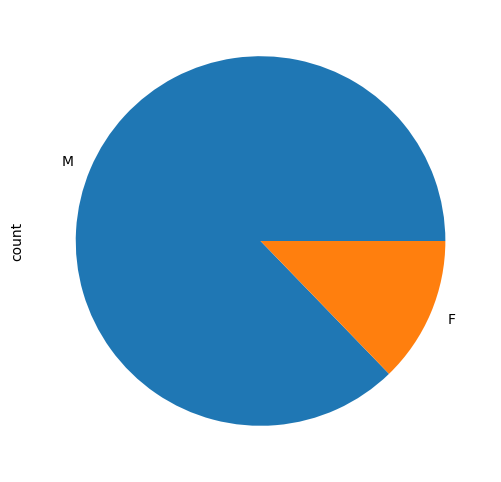

In [16]:
df['gender'].value_counts().plot(kind='pie', figsize=(6,6))

In [17]:
df['age'].mean()

65.03863636363636

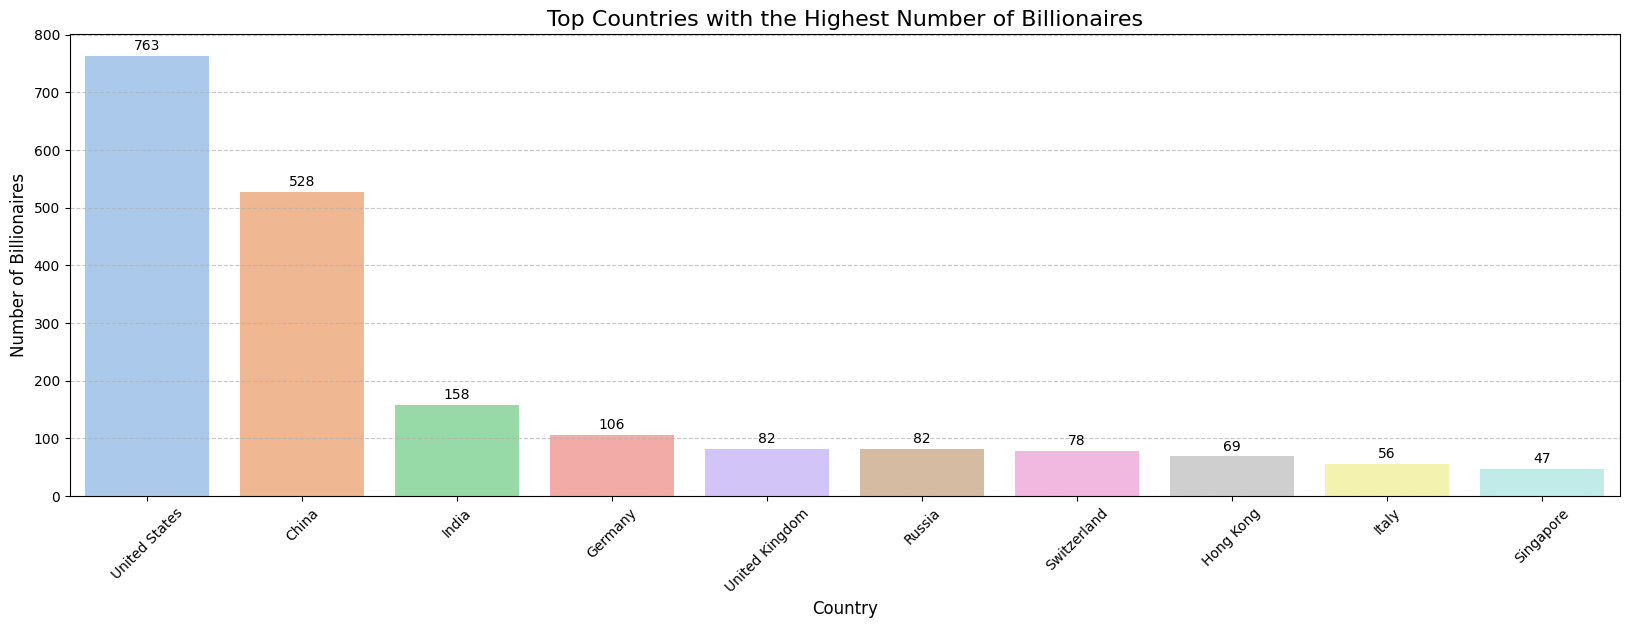

In [18]:
top_countries =  df['country'].value_counts().head(10)

colors = sns.color_palette("pastel")

plt.figure(figsize=(20, 6))
sns.barplot(x=top_countries.index, y=top_countries, palette=colors)
plt.title('Top Countries with the Highest Number of Billionaires', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Billionaires', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(top_countries):
    plt.text(i, v + 5, str(v), color='black', ha='center', va='bottom', fontsize=10)

plt.show()

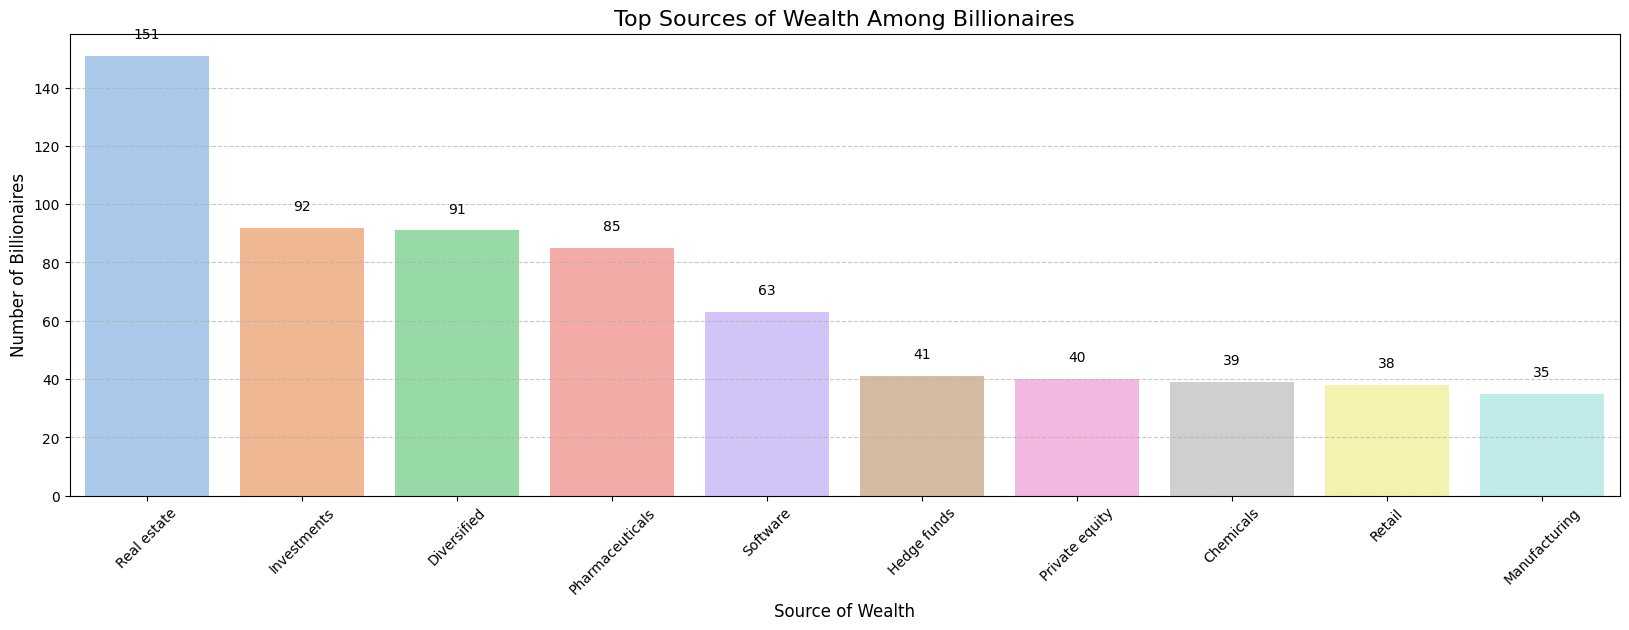

In [19]:
top_sources = df['source'].value_counts().head(10)

colors = sns.color_palette("pastel")

plt.figure(figsize=(20, 6))
sns.barplot(x=top_sources.index, y=top_sources, palette=colors)
plt.title('Top Sources of Wealth Among Billionaires', fontsize=16)
plt.xlabel('Source of Wealth', fontsize=12)
plt.ylabel('Number of Billionaires', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(top_sources):
    plt.text(i, v + 5, str(v), color='black', ha='center', va='bottom', fontsize=10)

plt.show()

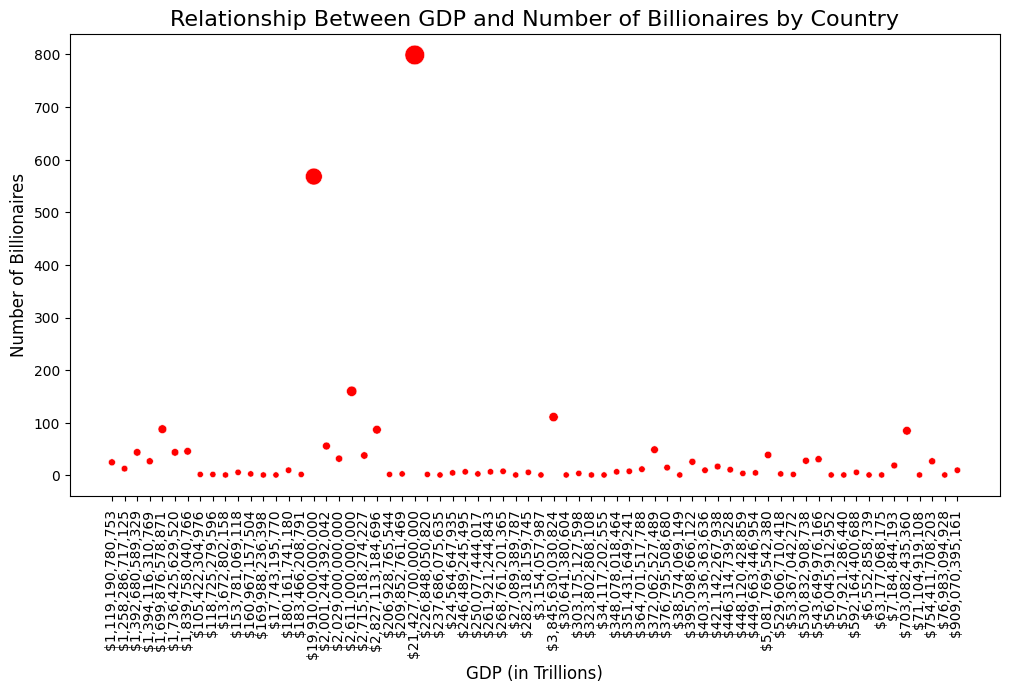

In [20]:
gdp_billionaires = df.groupby('gdp_country')['rank'].count().reset_index()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=gdp_billionaires, x='gdp_country', y='rank', size='rank', sizes=(20, 200), color='red', legend=False)
plt.title('Relationship Between GDP and Number of Billionaires by Country', fontsize=16)
plt.xlabel('GDP (in Trillions)', fontsize=12)
plt.ylabel('Number of Billionaires', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)

plt.show()

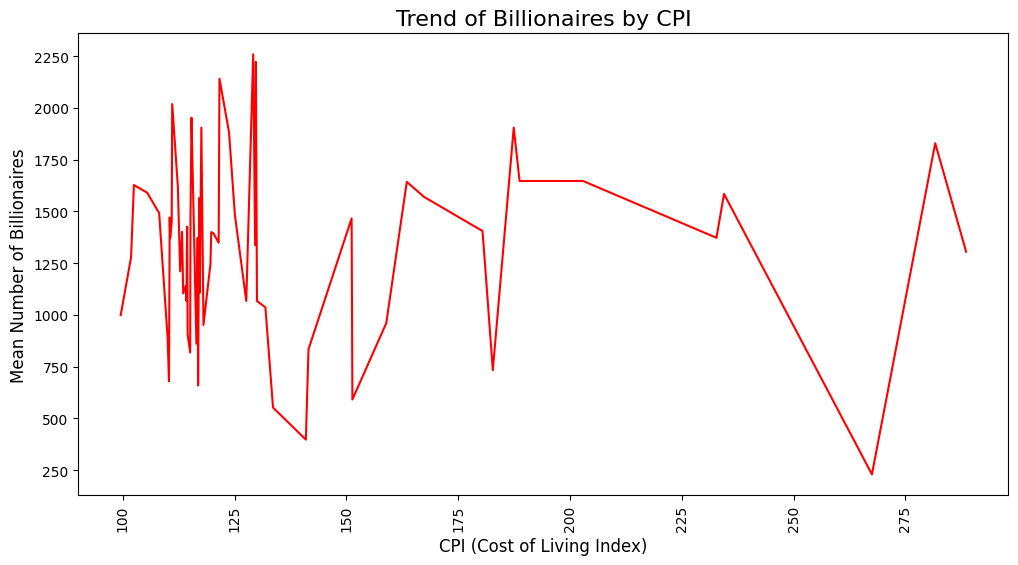

In [22]:
cpi_billionaires = df.groupby('cpi_country')['rank'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=cpi_billionaires, x='cpi_country', y='rank', color='red')
plt.title('Trend of Billionaires by CPI', fontsize=16)
plt.xlabel('CPI (Cost of Living Index)', fontsize=12)
plt.ylabel('Mean Number of Billionaires', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [23]:
population_correlation = df['population_country'].corr(df['rank'])

print(f'Correlation between Population and Number of Billionaires: {population_correlation:.2f}')

Correlation between Population and Number of Billionaires: 0.12


In [26]:
top_countries_billionaires = df['country'].value_counts().head(10).index
average_tax_rate = df[df['country'].isin(top_countries_billionaires)]['total_tax_rate_country'].mean()

print(f'Average Total Tax Rate in Countries with the Most Billionaires: {average_tax_rate:.2f}')


Average Total Tax Rate in Countries with the Most Billionaires: 44.76


In [73]:
df['finalWorth_round'] = df['finalWorth'].apply(lambda x: round(x, 2))
total_wealth = df.groupby('country')['finalWorth'].sum().reset_index()


In [74]:
total_wealth_all_countries = total_wealth['finalWorth'].sum()

In [75]:
def calculate_percentage(row):
    return (row['finalWorth'] / total_wealth_all_countries) * 100

total_wealth['Percentage'] = total_wealth.apply(calculate_percentage, axis=1)

In [76]:
print(total_wealth)

                     country  finalWorth  Percentage
0                    Andorra        1500        0.02
1                    Armenia        1200        0.01
2                    Austria       40700        0.45
3                    Bahamas        8200        0.09
4                    Bahrain        1500        0.02
5                    Belgium        2300        0.03
6                    Bermuda        4600        0.05
7     British Virgin Islands        3400        0.04
8                   Cambodia        2800        0.03
9                     Canada      122500        1.37
10            Cayman Islands       10900        0.12
11                     China     1661000       18.56
12                  Colombia        6400        0.07
13                    Cyprus        9600        0.11
14            Czech Republic       42800        0.48
15      Eswatini (Swaziland)        6500        0.07
16                   Finland       14000        0.16
17                    France      170000      

In [31]:
import folium
from folium.plugins import MarkerCluster

m = folium.Map(location=[0, 0], zoom_start=2)

marker_cluster = MarkerCluster()

for index, row in df.iterrows():
    if not pd.isna(row['latitude_country']) and not pd.isna(row['longitude_country']):
        folium.Marker([row['latitude_country'], row['longitude_country']]).add_to(marker_cluster)

marker_cluster.add_to(m)

m

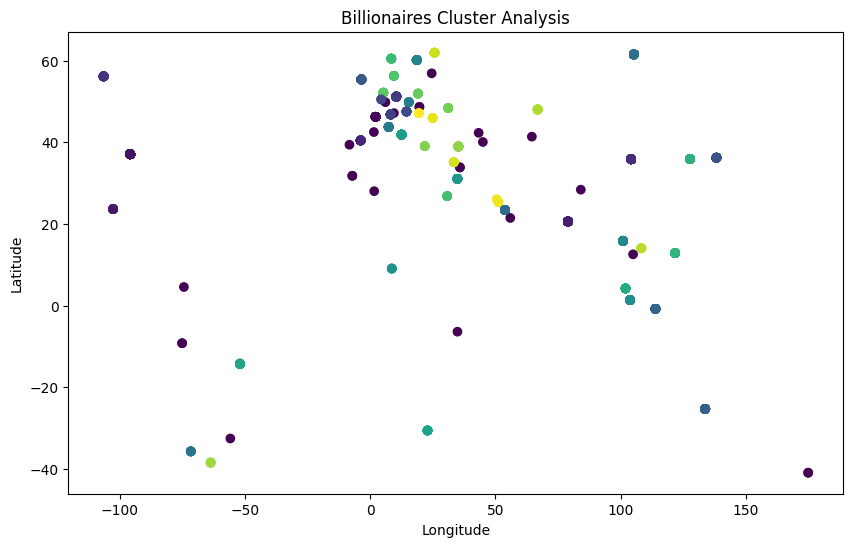

In [33]:
from sklearn.cluster import DBSCAN

valid_locations = df.dropna(subset=['latitude_country', 'longitude_country'])

locations = valid_locations[['latitude_country', 'longitude_country']]

dbscan = DBSCAN(eps=1, min_samples=3)
dbscan.fit(locations)

valid_locations['cluster'] = dbscan.labels_

plt.figure(figsize=(10, 6))
plt.scatter(valid_locations['longitude_country'], valid_locations['latitude_country'], c=valid_locations['cluster'], cmap='viridis')
plt.title('Billionaires Cluster Analysis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [34]:
# Filter for under 40 or exactly 40  
age_criteria = (df['age'] <= 40)

# Filter for net worth over 1 billion
worth_criteria = (df['finalWorth'] > 1) 

# Filter dataframe with both criteria
df_filtered = df[age_criteria & worth_criteria]

# Count number of rows (billionaires) 
num_billionaires = df_filtered.shape[0]

print(f"Number of billionaires under 40 or exactly 40: {num_billionaires}")

Number of billionaires under 40 or exactly 40: 89


In [35]:
# Filter for under 40 or exactly 40
criteria = (df['age'] <= 40)

# Filter dataframe 
df_filtered = df[criteria]

# Count number that are self-made
num_self_made = df_filtered[df_filtered['selfMade'] == True]['personName'].count()

print(f"Number of self-made billionaires under 40 or exactly 40: {num_self_made}")

Number of self-made billionaires under 40 or exactly 40: 49


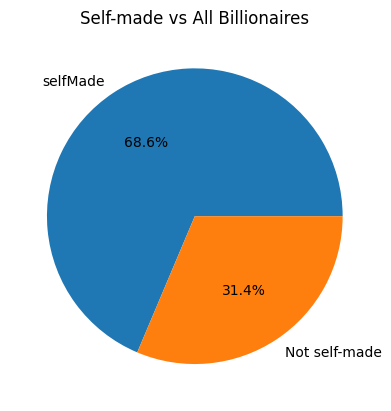

In [36]:
# Filter for billionaires  
criteria = (df['finalWorth'] > 1)
df_billionaires = df[criteria]

# Count total billionaires
total_billionaires = df_billionaires.shape[0]

# Count self-made billionaires  
self_made = df_billionaires[df_billionaires['selfMade']]
num_self_made = self_made.shape[0]

# Pie chart labels and values
labels = ['selfMade', 'Not self-made']
sizes = [num_self_made, total_billionaires - num_self_made]

# Plot
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Self-made vs All Billionaires')
plt.show()

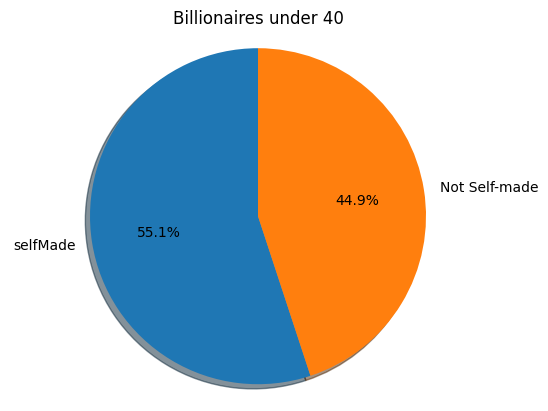

In [37]:


# Filter for under 40 or exactly 40  
age_criteria = (df['age'] <= 40)

# Filter for net worth over 1 billion
worth_criteria = (df['finalWorth'] > 1)  

# Filter dataframe with both criteria
df_filtered = df[age_criteria & worth_criteria]

# Count self-made billionaires 
num_self_made = df_filtered[df_filtered['selfMade']].shape[0]

# Count total billionaires
num_total = df_filtered.shape[0]

# Plot pie chart
labels = ['selfMade', 'Not Self-made']
sizes = [num_self_made, num_total-num_self_made]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Billionaires under 40")
plt.show()


In [38]:
df['industries'].value_counts()

industries
Finance & Investments         372
Manufacturing                 324
Technology                    314
Fashion & Retail              266
Food & Beverage               212
Healthcare                    201
Real Estate                   193
Diversified                   187
Energy                        100
Media & Entertainment          91
Metals & Mining                74
Automotive                     73
Service                        53
Construction & Engineering     45
Logistics                      40
Sports                         39
Telecom                        31
Gambling & Casinos             25
Name: count, dtype: int64

<Figure size 2500x2000 with 0 Axes>

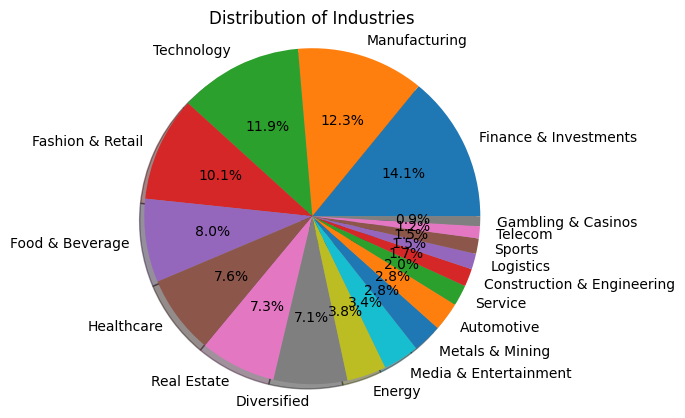

In [39]:
# Get value counts of industries  
industry_counts = df['industries'].value_counts()

# Plot pie chart
labels = industry_counts.index
sizes = industry_counts.values

# Create a larger figure
fig = plt.figure(figsize=(25, 20))  

# Rest of the code...

fig1, ax1 = plt.subplots() 

ax1.pie(sizes, labels=labels, autopct='%1.1f%%',  
        shadow=True, startangle=360)

ax1.axis('equal')

plt.title("Distribution of Industries")

plt.show()


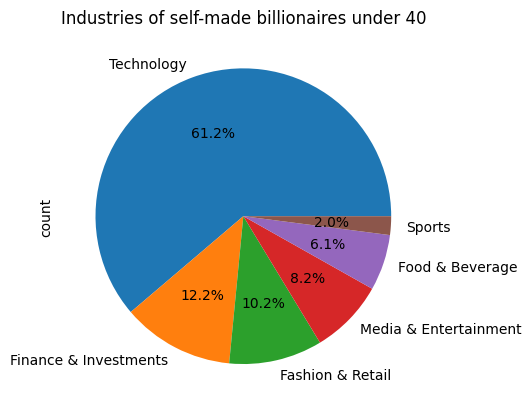

In [40]:
# Filter for under 40 or exactly 40
age_criteria = (df['age'] <= 40)

# Filter for net worth over 1 billion  
worth_criteria = (df['finalWorth'] > 1)

# Filter for self-made  
self_made_criteria = (df['selfMade'] == True) 

# Apply all filters
df_filtered = df[age_criteria & worth_criteria & self_made_criteria]

# Get value counts of industries   
industry_counts = df_filtered['industries'].value_counts()

# Plot pie chart
industry_counts.plot.pie(autopct='%1.1f%%')
plt.title("Industries of self-made billionaires under 40")
plt.show()

Pearson Correlation between Wealth and GDP: 0.04
Pearson Correlation between Wealth and CPI: -0.04
Pearson Correlation between Wealth and Total Tax Rate: -0.04


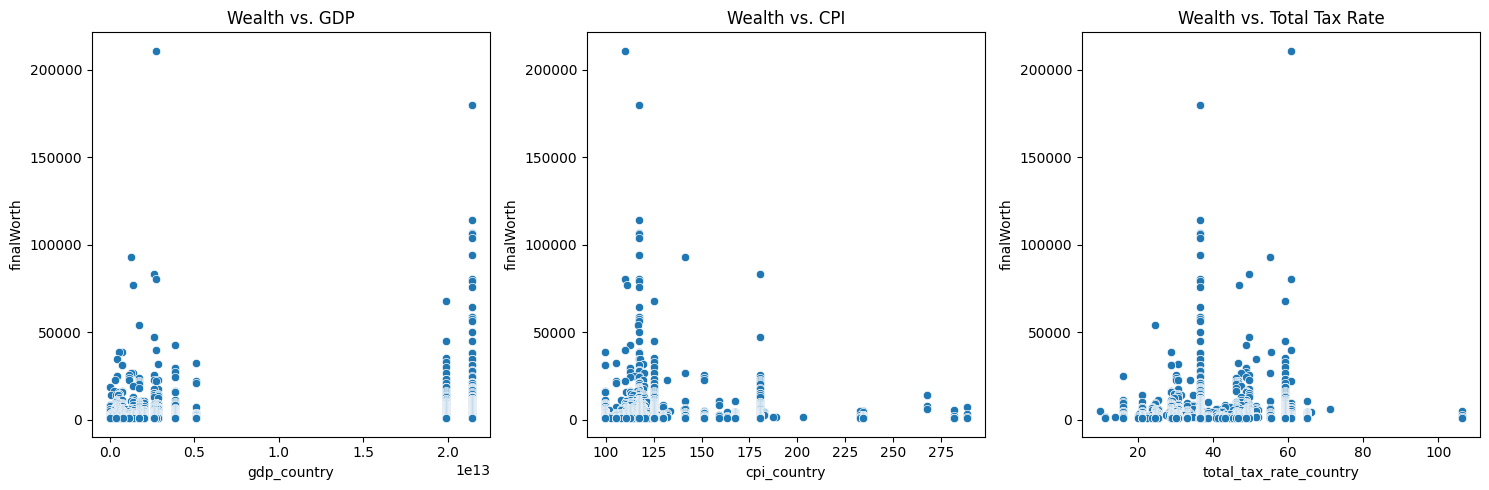

In [57]:


# Calculate correlation coefficients
wealth_gdp_correlation = df['finalWorth'].corr(df['gdp_country'])
wealth_cpi_correlation = df['finalWorth'].corr(df['cpi_country'])
wealth_tax_rate_correlation = df['finalWorth'].corr(df['total_tax_rate_country'])

print(f"Pearson Correlation between Wealth and GDP: {wealth_gdp_correlation:.2f}")
print(f"Pearson Correlation between Wealth and CPI: {wealth_cpi_correlation:.2f}")
print(f"Pearson Correlation between Wealth and Total Tax Rate: {wealth_tax_rate_correlation:.2f}")

# Create scatter plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x='gdp_country', y='finalWorth', data=df)
plt.title('Wealth vs. GDP')

plt.subplot(1, 3, 2)
sns.scatterplot(x='cpi_country', y='finalWorth', data=df)
plt.title('Wealth vs. CPI')

plt.subplot(1, 3, 3)
sns.scatterplot(x='total_tax_rate_country', y='finalWorth', data=df)
plt.title('Wealth vs. Total Tax Rate')

plt.tight_layout()
plt.show()

In [58]:


# Get the correlation matrix of the numerical columns
corr_matrix = df[numerical_columns].corr()

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, ax=ax)

NameError: name 'numerical_columns' is not defined

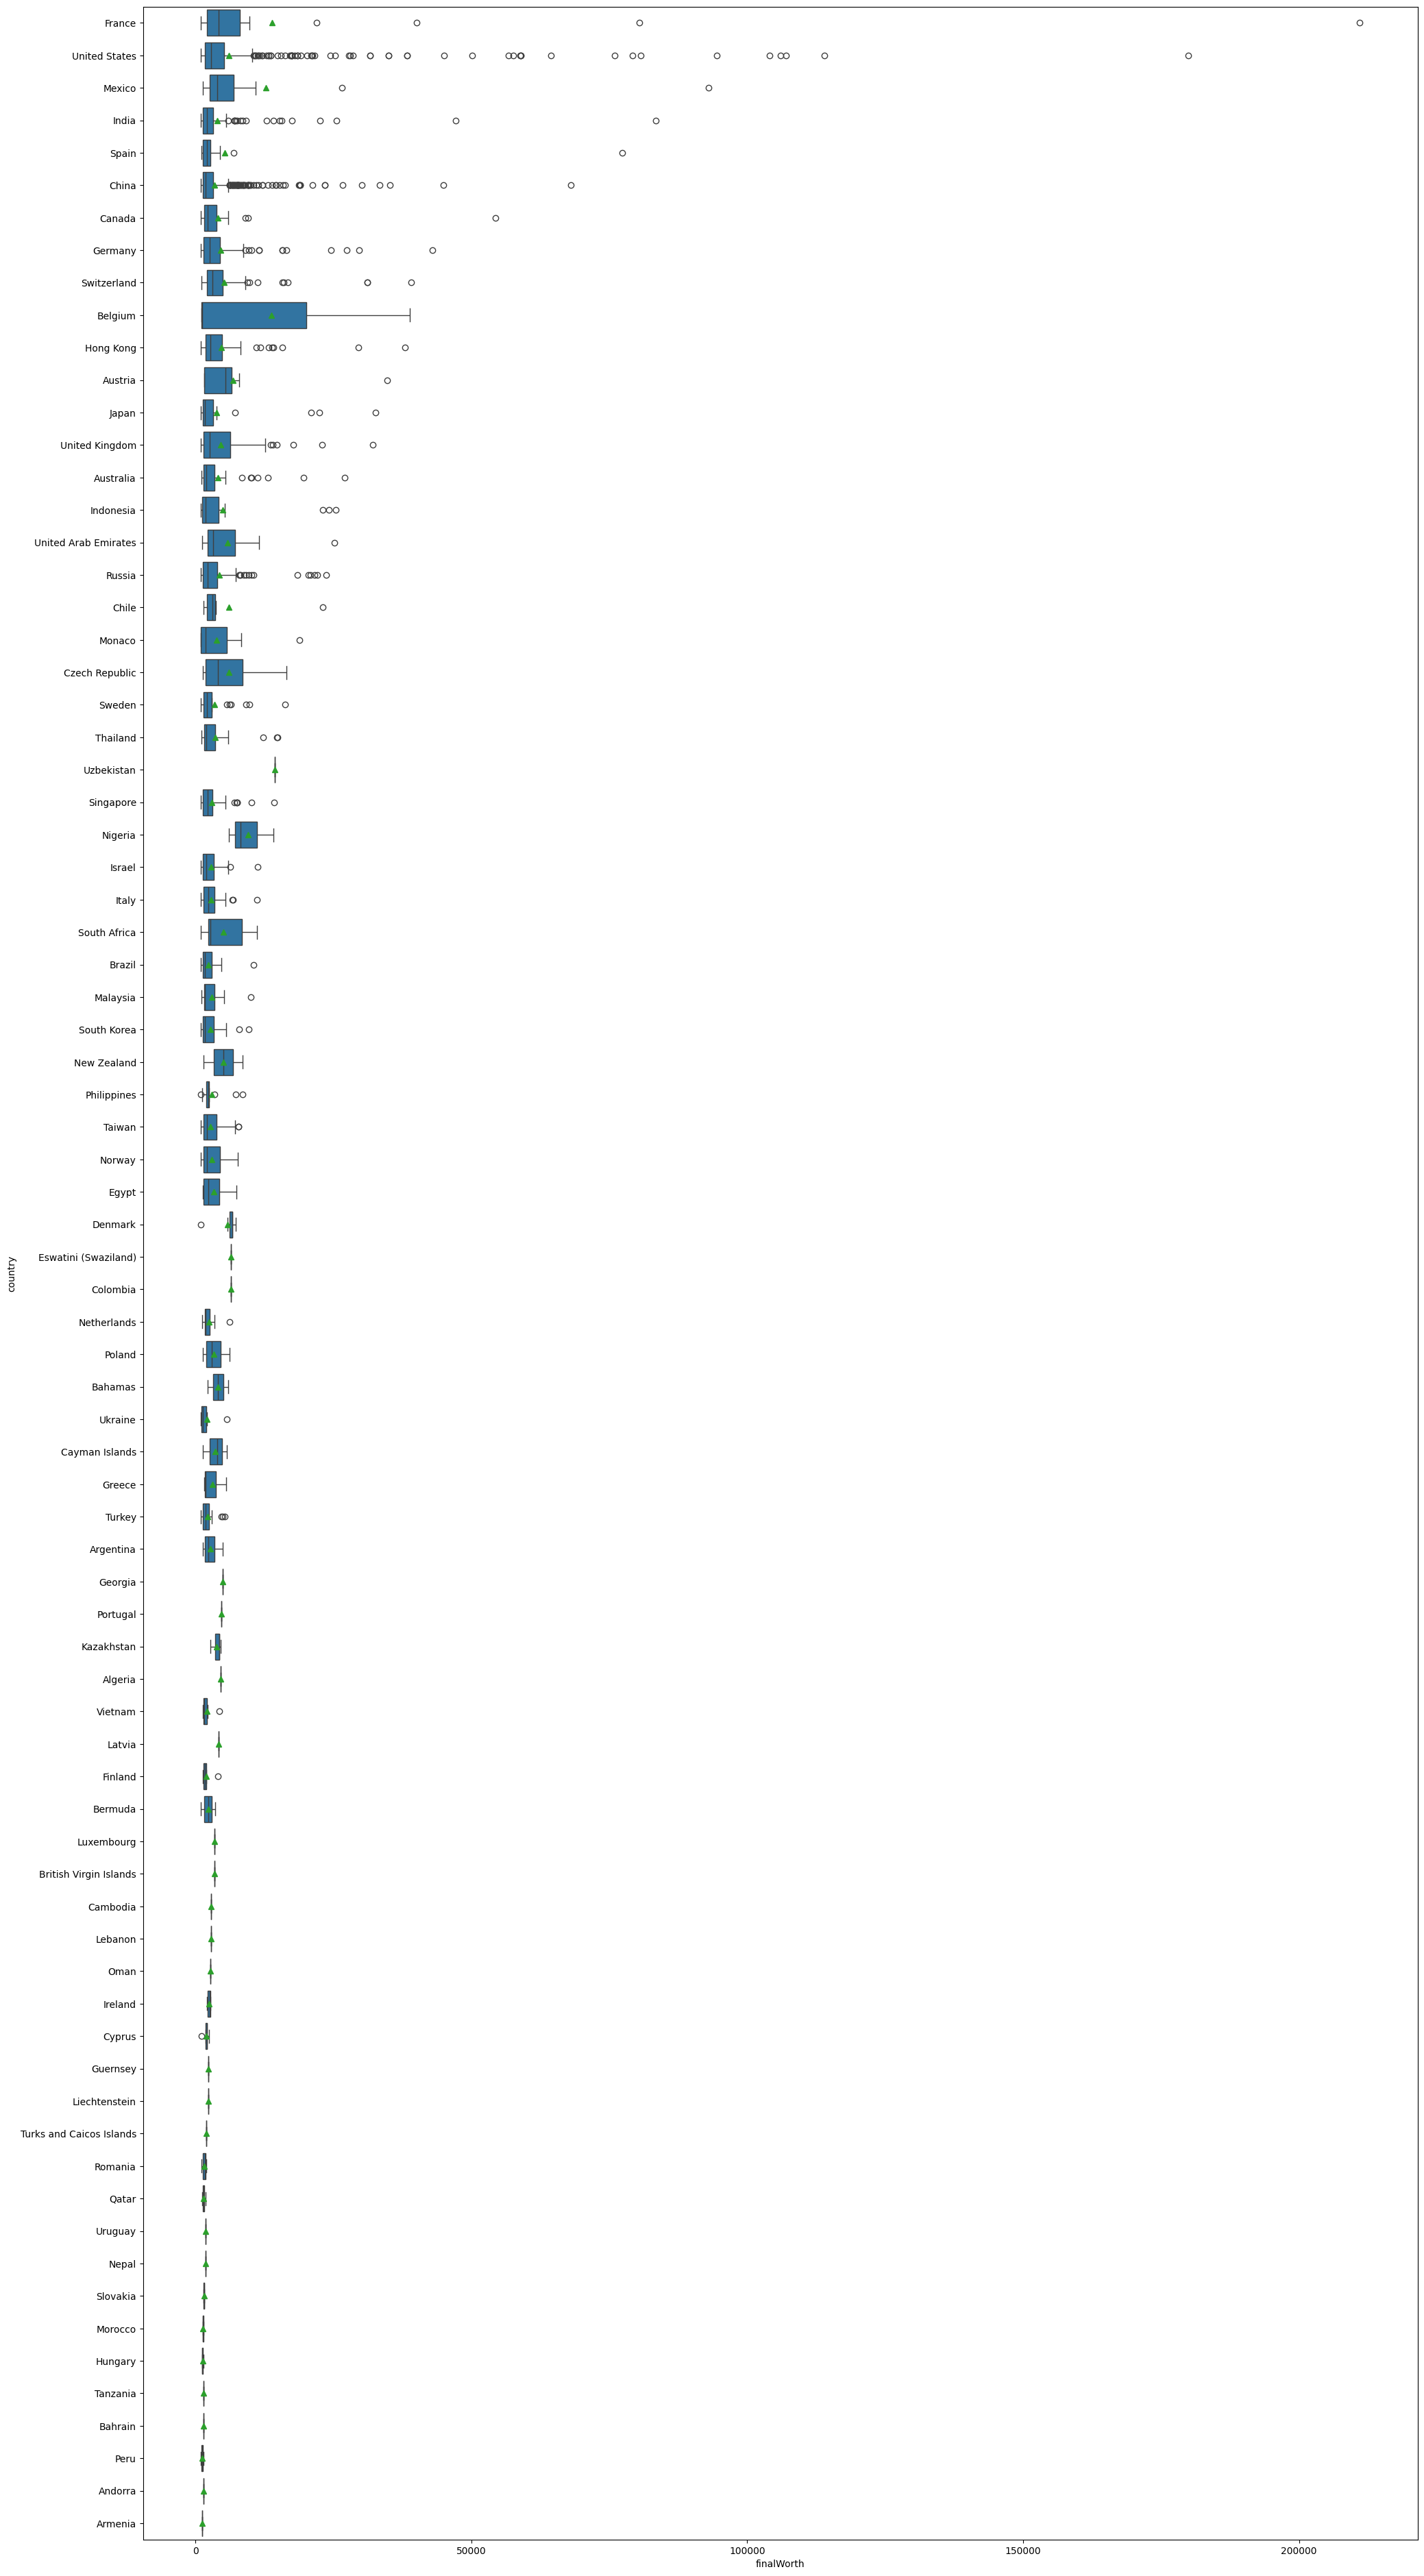

In [59]:


fig, ax = plt.subplots(figsize=(24, 48))


# Box plot of final worth by country
sns.boxplot(
    y='country',
    x='finalWorth',
    showmeans=True,
    data=df, ax=ax
)
plt.show()

In [55]:
groupbby_year=df[['birthDate','gross_tertiary_education_enrollment','gross_primary_education_enrollment_country',
                  'cpi_country']].groupby([pd.Grouper(key='birthDate',freq='Y')]).mean()

fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

# pass the graph objects to the add trace method, assign a series to x and y parameters of graph objects.
fig.add_trace(go.Scatter(x=groupbby_year.index, y=groupbby_year.gross_tertiary_education_enrollment, mode='lines',
                         line_color='#AF4343' ,name='gross_tertiary'),row=1,col=1)
fig.add_trace(go.Scatter(x=groupbby_year.index, y=groupbby_year.gross_primary_education_enrollment_country,mode='lines',
                         line_color='#fcbca2',name='gross_primary'),row=2,col=1)
fig.add_trace(go.Scatter(x=groupbby_year.index, y=groupbby_year.cpi_country,  mode='lines',
                         name='cpi_country',line_color='#B7A294'),row=3,col=1)


fig.update_xaxes(rangeslider_visible=False,
                 rangeselector=dict(
                     buttons=list([
                         dict(count=20, label="20y", step="year", stepmode="backward"),
                         dict(count=40, label="40y", step="year", stepmode="backward"),
                         dict(count=60, label="60y", step="year", stepmode="backward"),
                         dict(step="all")])),
                 row=1,col=1)

temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12)))
fig.update_traces(marker=dict(line=dict(width=1, color='#000000')))
fig.update_layout(title="Date of Self Made Data",
                  yaxis1_title='gross_tertiary', 
                  yaxis2_title='gross_primary',
                  yaxis3_title='cpi_country',
                  showlegend=True, template=temp, 
                  legend=dict(orientation="h", yanchor="bottom", y=1, xanchor="right", x=.97),
                  barmode='group', bargap=.15)
fig.show()

In [ ]:
dftrain = pd.read_csv('C:\\Users\\mercy\\Desktop\\data cleaning\\Billionaires Statistics Dataset.csv')
dfeval = pd.read_csv('C:\\Users\\mercy\\Desktop\\data cleaning\\Billionaires Statistics Dataset.csv')
y_train = dftrain.pop('gender')
y_eval = dfeval.pop('gender')


In [53]:
# `birthYear`, `birthMonth` and `birthDay` these data types are float  so I will convert it to interger
df['birthYear']=df['birthYear'].astype(int)
df['birthMonth']=df['birthMonth'].astype(int)
df['birthDay']=df['birthDay'].astype(int)

# convert `birthDate` column to Datetimeindex
df['birthDate']=pd.to_datetime(df['birthDate'])

In [54]:
# gdp_country column has object data type because the values start with $ so I will convert it to float
df['gdp_country'] = df['gdp_country'].str.replace('$','').replace(',','', regex=True).astype(float)

In [60]:
from scipy import stats
num_outlier=[]
num_cols = df.select_dtypes(include=['float64','int64'])
print("There are {:,} observations in the data before delete the outliers.".format(df.shape[0]))

for column in num_cols.columns:
    # Calculate the z-score for each student's height
    z = np.abs(stats.zscore(df[column]))

    # Identify outliers as students with a z-score greater than 3
    threshold = 3
    outliers = df[z > threshold]
    num_outlier.append(len(outliers))
    # drop rows containing outliers
    df.drop(outliers.index,inplace=True)    
    
print("There are {:,} observations in the data after delete the outliers.".format(df.shape[0]))    
df_outlier=pd.DataFrame({"column":num_cols.columns,"number_of_outliers":num_outlier})
df_outlier

There are 2,640 observations in the data before delete the outliers.
There are 2,398 observations in the data after delete the outliers.


,column,number_of_outliers
0,rank,0
1,finalWorth,37
2,age,6
3,cpi_country,46
4,cpi_change_country,0
5,gdp_country,0
6,gross_tertiary_education_enrollment,4
7,gross_primary_education_enrollment_country,34
8,life_expectancy_country,8
9,tax_revenue_country_country,10


In [62]:
fig = px.scatter(df, x='gross_tertiary_education_enrollment', y='gross_primary_education_enrollment_country',
                 color='selfMade', size='life_expectancy_country',
                 title="gross_tertiary with gross_primary",
                 color_discrete_sequence=['#B14B51','#B7A294'],height=600)

temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12)))
fig.update_layout(template=temp,legend=dict(title='',orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    font_color="#303030", 
    xaxis=dict(title='gross_tertiary',showgrid=False,zerolinecolor='#E5E5EA',showline=True, linecolor='#E5E5EA', linewidth=2), 
    yaxis=dict(title='gross_primary',showgrid=False,zerolinecolor='#E5E5EA',showline=True, linecolor='#E5E5EA', linewidth=2))
fig.show()

In [63]:
pal = sns.color_palette("Reds_r", 6).as_hex()

fig = px.bar(x=df.status.value_counts().sort_values(ascending=False).index,
             y=df.status.value_counts().sort_values(ascending=False).values,
             text=df.status.value_counts().sort_values(ascending=False).values, 
             color=df.status.value_counts().sort_values(ascending=False).index,
             color_discrete_sequence=pal, opacity=0.8)

temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12)))
fig.update_traces(texttemplate='%{text}', textposition='outside',
                  marker_line=dict(width=1, color='#28221D'))
fig.update_yaxes(visible=False, showticklabels=False)
fig.update_layout(template=temp, title_text='Number of Status', 
                  xaxis=dict(title='', tickangle=25, showline=True), 
                  height=450, width=700, showlegend=False)
fig.show()

In [64]:
(df.birthDate.max()-df.birthDate.min())

Timedelta('27344 days 00:00:00')

In [77]:
#rank column has values from 1 to 2540 in order and if these values enter the model, the model will be miss leading so I will collect every 500 ranks to be 1 rank
df['rank']=pd.cut(df['rank'],[0,500,1000,1500,2000,2600],labels=[1,2,3,4,5])

In [86]:
df.drop(columns=['country','state','birthDate','birthDay','birthMonth','birthYear'],inplace=True)

In [99]:
# Transform target and features
y = df['selfMade']
X = df.drop('selfMade', axis=1)

# One-hot encode categorical columns
X = pd.get_dummies(X, columns=['status','gender'], drop_first=True) 

# Select only numeric columns  
numeric_cols = X.select_dtypes(include=['number'])

# Create interaction features
pf = PolynomialFeatures(interaction_only=True, include_bias=False)

# Fit and transform on numeric columns
X_pf = pd.DataFrame(pf.fit_transform(numeric_cols),  
                     columns=pf.get_feature_names_out(numeric_cols.columns))


# Join categorical and interaction features 
X = pd.concat([X, X_pf], axis=1)

print("New data shape:", X.shape)
X.head()



New data shape: (2623, 129)


,rank,finalWorth,personName,age,source,industries,cpi_country,cpi_change_country,gdp_country,gross_tertiary_education_enrollment,...,total_tax_rate_country population_country,total_tax_rate_country latitude_country,total_tax_rate_country longitude_country,total_tax_rate_country finalWorth_round,population_country latitude_country,population_country longitude_country,population_country finalWorth_round,latitude_country longitude_country,latitude_country finalWorth_round,longitude_country finalWorth_round
37,1,"33,400.00",Robin Zeng,54.00,Batteries,Automotive,125.08,2.90,"19,910,000,000,000.00",50.60,...,"12,013,566,541.80","1,357.50","-3,503.09","768,600.00","12,174,482,685.56","-31,416,753,686.79","6,893,029,983,000.00","-3,550.01","778,895.04","-2,009,970.71"
38,1,"32,600.00",Tadashi Yanai & family,74.00,Fashion retail,Fashion & Retail,105.48,0.50,"5,081,769,542,380.00",63.20,...,"5,894,780,725.60","1,690.77","6,456.41","980,700.00","4,570,010,678.56","17,451,192,112.48","2,650,757,928,000.00","5,005.42","760,301.30","2,903,311.40"
39,1,"32,100.00",Len Blavatnik,65.00,"Music, chemicals",Diversified,119.62,1.70,"2,827,113,184,696.00",60.00,...,"6,670,057,317.00","2,842.41","4,865.73","965,580.00","8,882,438,811.08","15,205,241,105.52","3,017,406,881,500.00","6,479.63","1,285,851.81","2,201,162.00"
40,1,"31,600.00",Alain Wertheimer,74.00,Chanel,Fashion & Retail,117.24,7.50,"21,427,700,000,000.00",88.20,...,"6,670,057,317.00","2,842.41","4,865.73","947,100.00","8,882,438,811.08","15,205,241,105.52","2,959,657,467,500.00","6,479.63","1,261,242.20","2,159,034.50"
41,1,"31,600.00",Gerard Wertheimer,72.00,Chanel,Fashion & Retail,117.24,7.50,"21,427,700,000,000.00",88.20,...,"12,013,566,541.80","1,357.50","-3,503.09","739,320.00","12,174,482,685.56","-31,416,753,686.79","6,630,438,364,600.00","-3,550.01","749,222.85","-1,933,400.40"


In [100]:
var_thr = VarianceThreshold(threshold = 0.25) #Removing both constant and quasi-constant
var_thr.fit(X_pf)

var_thr.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [101]:
# Picking Up the low Variance Columns
concol = [column for column in X_pf.columns 
          if column not in X_pf.columns[var_thr.get_support()]]

for features in concol:
    print(features)

In [102]:
# Dropping Low Variance Columns
X_pf.drop(concol,axis=1,inplace=True)
print("New data shape with interaction terms:",X_pf.shape)

New data shape with interaction terms: (2398, 105)


In [103]:
# Scale features
scaler=StandardScaler()
X_pf=pd.DataFrame(scaler.fit_transform(X_pf), columns=X_pf.columns)

In [104]:
# Create training sets
X_train, X2, y_train, y2 = train_test_split(X_pf, y, train_size=0.5, shuffle=True, 
                                            stratify=y, random_state=55)

# Create validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X2, y2, test_size=0.5, shuffle=True,
                                                stratify=y2, random_state=55)

print("Train Shape:",X_train.shape)
print("Validation Shape:",X_val.shape)
print("Test Shape:",X_test.shape)

Train Shape: (1199, 105)
Validation Shape: (599, 105)
Test Shape: (600, 105)


6 | Modeling
7 STEPS TO MODEL DEVELOPMENT(training), VALIDATION AND TESTING:

1) Create the development, validation and testing data sets.
2) Use the training data set to develop your model.
3) Compute statistical values identifying the model development performance.
4) Calculate the model results to the data points in the validation data set.
5) Compute statistical values comparing the model results to the validation data.
6) Calculate the model results to the data points in the testing data set.
7) Compute statistical values comparing the model results to the test data.

# 6.1| Create the development, validation and testing data sets.
# I do that in the above cell.

In [105]:

models= [RandomForestClassifier(), ExtraTreesClassifier(),  GradientBoostingClassifier(),XGBClassifier()]

train_score=[]
validation_score=[]

for model in models:
    # 6.2| Use the training data set to develop your model.
    model.fit(X_train,y_train)
    # 6.3| Compute statistical values identifying the model development performance.
    y_train_pred= model.predict(X_train)
    train_score.append(f1_score(y_train_pred,y_train))
    # 6.4| Calculate the model results to the data points in the validation data set.
    y_val_pred=model.predict(X_val)
    # 6.5| Compute statistical values comparing the model results to the validation data.
    validation_score.append(f1_score(y_val_pred,y_val))
    

In [106]:
f2=go.Figure()
models= ['RandomForestClassifier', 'ExtraTreesClassifier', 'GradientBoostingClassifier','XGBClassifier']

f2.add_trace(go.Bar(x=models, y=train_score, name='Train', text=train_score , textposition='outside',
                     texttemplate='%{text:.2f}%', width=0.38, 
                     hovertemplate='accuracy of %{x} = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#AF4343', opacity=0.8)))
f2.add_trace(go.Bar(x=models, y=validation_score, name='validation', text=validation_score, textposition='outside',
                     texttemplate='%{text:.2f}%', width=0.38, 
                     hovertemplate='accuracy of %{x} = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#C6AA97', opacity=0.8)))


temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12)))
f2.update_traces(marker=dict(line=dict(width=1, color='#000000')))
f2.update_layout(title="Model Comparision", showlegend=True, template=temp, 
                  legend=dict(orientation="h", yanchor="bottom", y=1, xanchor="right", x=.97),
                  barmode='group', bargap=.15)
f2.update_yaxes(range=(0,1.1))

There is overfitting in all models so I will select the RandomForestClassifier, but I can fix it by using GridSearchCV to tune hyperparameters.
I will retrain both the train and validation sets together to improve their performance.
#  Retrain the best model on both train and validation data

In [107]:

X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

In [111]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

# Set the random seed for reproducibility
random_state = 25
np.random.seed(random_state)

# Create the RandomForestClassifier model
model = RandomForestClassifier(class_weight='balanced', random_state=random_state)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train_val, y_train_val)

# Retrieve the best model and best parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Retrain the best model on the entire training set
best_model.fit(X_train_val, y_train_val)

# Evaluate the performance of the best model on the test set using f1_score
y_train_val_pred = best_model.predict(X_train_val)
f1_train = f1_score(y_train_val_pred, y_train_val)

# Calculate the model results on the testing data set.
y_test_pred = best_model.predict(X_test)

# Compute statistical values comparing the model results to the test data.
f1_test = f1_score(y_test_pred, y_test)

print('F1-score on the train set:', f1_train)
print('F1-score on the test set:', f1_test)


In [ ]:
# Subplot 1: Confusion Matrix
from matplotlib.colors import LinearSegmentedColormap

cm = confusion_matrix(y_test,y_test_pred ,labels=[0,1])
plt.subplots_adjust(hspace=0.5)
warm=LinearSegmentedColormap.from_list('warm', 
                                       [(0, '#EBD5C8'), 
                                        (0.25, '#E1C1AD'),
                                        (.75, '#D77873'), 
                                        (1, '#C8504A')], N=256)

fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,5))

classes=['Self Made','No Self Made']
label = ['True Positives', 'False Negatives', 'False Positives', 'True Negatives']
annot = [f'{i}\n\n{j}' for i, j in zip(cm.flatten(), label)]
annot = np.asarray(annot).reshape(2,2)

sns.set_context('notebook') 
sns.heatmap(cm, annot=annot, fmt='', cmap=warm, linecolor='white', linewidths=8, ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('\nPredicted Label')
ax[0].set_ylabel('True Label\n')
ax[0].xaxis.set_ticklabels(classes)
ax[0].yaxis.set_ticklabels(classes)

# Subplot 2: AUC

y_proba= best_model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])
roc_auc = auc(fpr, tpr)
RocCurveDisplay.from_estimator(best_model, X_test, y_test,ax=ax[1],color="#AF4343")
sns.lineplot(x = [0, 1], y = [0, 1], color = 'gold', linestyle="dashed",ax=ax[1])
ax[1].set_title('RUC Curve')

plt.tight_layout()
plt.show();

In [ ]:
ft_importance=pd.DataFrame(index=X_pf.columns)

ft_importance['feature_importances']=best_model.feature_importances_  #ft_importance.mean(axis=1)
ft_importance=ft_importance.feature_importances.nlargest(50).sort_values(ascending=True)

pal=sns.color_palette("Reds_r", 50).as_hex()
fig=go.Figure()
for i in range(len(ft_importance.index)):
    fig.add_shape(dict(type="line", y0=i, y1=i, x0=0, x1=ft_importance[i], 
                       line_color=pal[::-1][i],opacity=0.8,line_width=4))
fig.add_trace(go.Scatter(x=ft_importance, y=ft_importance.index, mode='markers', 
                         marker_color=pal[::-1], marker_size=8,
                         hovertemplate='%{y} Importance = %{x:.0f}<extra></extra>'))
fig.update_layout(template=temp,title='LGBM Feature Importance<br>Top 50', 
                  margin=dict(l=150,t=80),
                  xaxis=dict(title='Importance', zeroline=False),
                  yaxis_showgrid=False, height=1000, width=800)
fig.show()
